In the excel, make sure to 

1) remove spaces in header (find and replace), and set 'n' to 0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import isnan

In [61]:
data = pd.read_excel(r'/Users/hellpark/Desktop/Bioinformatics/Fermentations/helen p june 15 pha sampling.xlsx', 
                   sheet_name = 'helen p june 15 pha sampling',
                  skiprows = 19, header = 0)
df = pd.DataFrame(data, columns=['time','abs-time',
                                'od-sensors.od-680','probes.ph', 'actinic-lights.light-Blue',
                                 'thermo.temperature','Propane','Isobutane'])

In [62]:
df['od-sensors.od-680'] = pd.to_numeric(df['od-sensors.od-680'],errors='coerce')
df['probes.ph'] = pd.to_numeric(df['probes.ph'],errors='coerce')
#df['actinic-lights.light-Blue'] = df['actinic-lights.light-Blue'].replace('n',0)
df['actinic-lights.light-Blue'] = df['actinic-lights.light-Blue'].replace(800,0.5)
df['actinic-lights.light-Blue'] = df['actinic-lights.light-Blue'].replace(2,1)
df['actinic-lights.light-Blue'] = pd.to_numeric(df['actinic-lights.light-Blue'],errors='coerce')
#df = df[df['od-sensors.od-680']>0]

In [63]:
for i in df.index:
    if isnan(df.at[i,'od-sensors.od-680']):
        j = i-1
        if j > 1:
            df.at[i,'od-sensors.od-680'] = df.at[j,'od-sensors.od-680']
            #print(i, df.at[i,'od-sensors.od-680'])
for i in df.index:
   # blue = df.iloc[i]['actinic-lights.light-Blue']
    if isnan(df.at[i,'actinic-lights.light-Blue']):
        j = i-1
        if j > 400:
            df.at[i,'actinic-lights.light-Blue'] = df.at[j,'actinic-lights.light-Blue']
            #print(i, df.at[i,'actinic-lights.light-Blue'])

In [64]:
#ml, ml, L/min, g/L wet weight
culture_v = 400
headspace_v = 115
air_flow = 1.21
od680 = 2.4
propane_area_per_uM = 8052
iso_area_per_uM = 9247
propane_MW = 44.1
uM_to_mg_per_hour = 0.06
df['Propane (mg/hr)'] = df['Propane']/iso_area_per_uM*uM_to_mg_per_hour*propane_MW*air_flow
df['Propane (g/L culture/day)'] = df['Propane (mg/hr)']*uM_to_mg_per_hour
df['Propane mg/gcells/day'] = df['Propane (g/L culture/day)']/(df['od-sensors.od-680']*od680)*1000
df['Isobutane (mg/hr)'] = df['Isobutane']/iso_area_per_uM*uM_to_mg_per_hour*58.12*air_flow
df['Isobutane (g/L culture/day)'] = df['Isobutane (mg/hr)']*uM_to_mg_per_hour
df['Isobutane mg/gcells/day'] = df['Isobutane (g/L culture/day)']/(df['od-sensors.od-680']*od680)*1000
#amount produced in 30 minues
df['Cumulative Propane'] = df['Propane mg/gcells/day']

In [56]:
df[1735:1740]

,time,abs-time,od-sensors.od-680,probes.ph,actinic-lights.light-Blue,thermo.temperature,Propane,Isobutane,Propane (mg/hr),Propane (g/L culture/day),Propane mg/gcells/day,Isobutane (mg/hr),Isobutane (g/L culture/day),Isobutane mg/gcells/day,Cumulative Propane
1735,24.082222,2021-06-15 09:23:34,1.30168,NaN,0.5,,9100.0,367.0,3.150763,0.189046,60.513395,0.167466,0.010048,3.216349,60.513395
1736,24.083333,2021-06-15 09:23:38,1.29542,6.9631,0.5,30.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1737,24.100000,2021-06-15 09:24:38,1.29542,6.9748,0.5,30.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1738,24.116667,2021-06-15 09:25:38,1.29542,6.9742,0.5,30.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1739,24.133333,2021-06-15 09:26:38,1.29542,6.9578,0.5,30.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df.at[101,'Cumulative Propane'] = 0.0
df.at[102,'Cumulative Propane'] = 0.0
df.at[103,'Cumulative Propane'] = 0.0
for i in df.index:
    j = i-1
    if j > 100:
        if isnan(df.at[i,'Propane mg/gcells/day']):
            propane = df.at[j,'Cumulative Propane'] 
        else:
            propane = df.at[i,'Propane mg/gcells/day'] / (24*2) + df.at[j,'Cumulative Propane']
        df.at[i,'Cumulative Propane'] = propane
            #print(i, df.at[i,'od-sensors.od-680'])

Def plot_fermentation - default is mg/gram cells / day. can adjust if wanted


1. plotph = true to plot ph

2. plot od = true to plot od

3. lightconnected = false to stop the light on and off from connecting to each other

4. cumulative = false to not have cumulative fermentation

In [66]:
def plot_fermentation(x1, x2, plotph=True, plotOD=True,lightconnected=False, cumulative=False):
    
    plt.figure()
    x = df['time']
    
    #Temp = df['thermo.temperature']
    Propane = np.array(df['Propane mg/gcells/day']).astype(np.double)
    propanemask = np.isfinite(Propane)
    Isobutane = np.array(df['Isobutane mg/gcells/day']).astype(np.double)
    isobutanemask = np.isfinite(Isobutane)
    cumulativepropane = np.array(df['Cumulative Propane']).astype(np.double)
    blue = np.array(df['actinic-lights.light-Blue']).astype(np.double)
    bluemask = np.isfinite(blue)
    OD680 = df['od-sensors.od-680']
    pH = df['probes.ph']
   # glucose = np.array(df['Glucose']).astype(np.double)
   # lactose = np.array(df['Lactate']).astype(np.double)
   # acetate = np.array(df['Acetic Acid']).astype(np.double)
   # butyrate = np.array(df['Butyric Acid']).astype(np.double)
   # glucosemask = np.isfinite(glucose)
   # lactosemask = np.isfinite(lactose)
   # acetatemask = np.isfinite(acetate)
   # butyratemask = np.isfinite(butyrate)

    fig, ax1 = plt.subplots(figsize=(15,6))

    #first axis
    ax1.set_xlabel('Time (hr)', size=20)
    ax1.set_ylabel('OD680', size=20)
    if(plotOD):
        ax1.plot(x,OD680,color='black',label='OD')
    if(lightconnected):
        ax1.plot(x,blue,color='darkblue',label='Light')
    else:
        ax1.scatter(x,blue, s=.5,color='darkblue',label='Light')
    ax1.tick_params(axis='y')
   # if hplc:
       # ax1.plot(x[glucosemask],glucose[glucosemask], linestyle='-', marker='o', color='chocolate',label='Glucose (10^-1 g)')
       # ax1.plot(x[acetatemask],acetate[acetatemask], linestyle='-', marker='o', color='gold',label='Acetate (10^-1 g)')
       # ax1.plot(x[lactosemask],lactose[lactosemask], linestyle='-', marker='o', color='aquamarine',label='Lactose/Glyerol (10^-1 g)')
      #  ax1.plot(x[butyratemask],butyrate[butyratemask], linestyle='-', marker='o', color='magenta',label='Butyrate (10^-1 g)')

    #second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Propane, pH',size=20)
    
    if not cumulative:
        ax2.plot(x[propanemask],Propane[propanemask], linestyle='-', marker='o', color='tab:blue',label='Propane (mg/gcell/day)')
        fig.suptitle('Propane production mg/g cell weight/day ',  fontsize=30)
        ax2.plot(x[isobutanemask],Isobutane[isobutanemask], linestyle='-', marker='o', color='darkblue',label='Isobutane (mg/gcell/day)')
        fig.suptitle('Isobutane production mg/g cell weight/day ',  fontsize=30)
        if(plotph):
            ax2.plot(x,pH, color='tab:orange',label='pH')
    else:
        ax2.plot(x,cumulativepropane, color='tab:blue',label='Propane (mg/gcell)')
        fig.suptitle('Propane production mg/g cell weight',  fontsize=30)
    ax2.tick_params(axis='y')

    line_labels = ['OD680', 'Propane', 'Isobutane' 'Light', 'pH']
    fig.legend([OD680, Propane, blue, pH],     
               labels=line_labels,loc='upper right', bbox_to_anchor=(0.25, .89),prop={'size': 15})
    ax1.set_xlim(xmin=x1,xmax=x2)
    ax2.set_xlim(xmin=x1,xmax=x2)
    ax1.set_ylim(ymin=0)
    #ax2.set_ylim(ymin=0)
    plt.show()
    # colors https://matplotlib.org/stable/gallery/color/named_colors.html

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

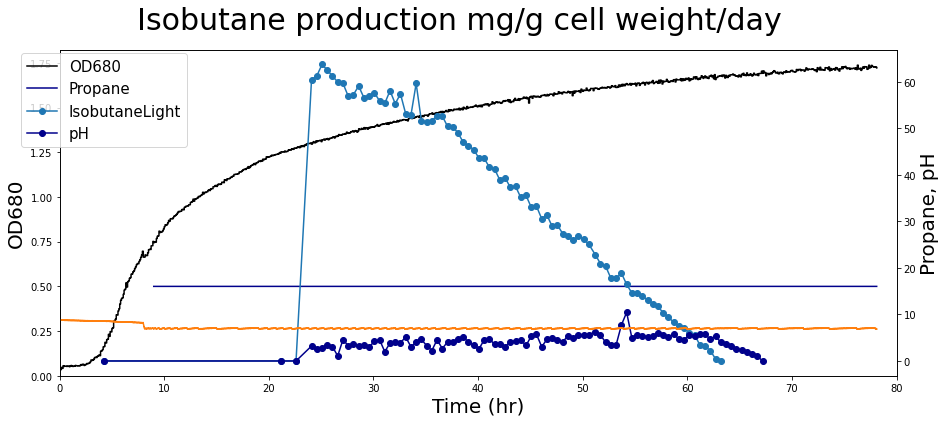

In [67]:
plot_fermentation(0,80,plotph=True, plotOD=True,lightconnected=True, cumulative=False)

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

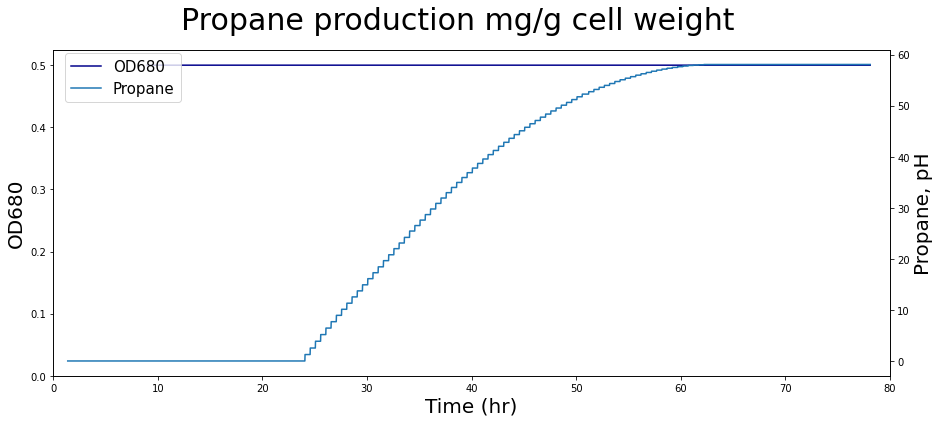

In [69]:
plot_fermentation(0,80,plotph=True, plotOD=False,lightconnected=True, cumulative=True)

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

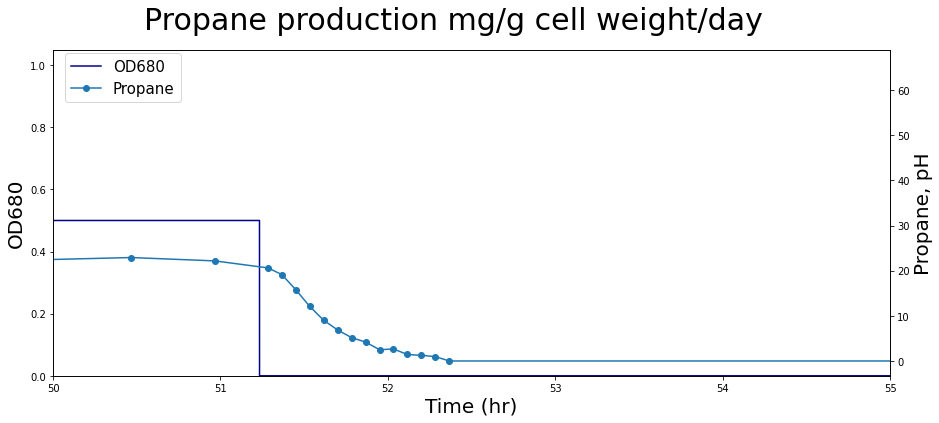

In [23]:
plot_fermentation(50,55,plotph=False, plotOD=False,lightconnected=True, cumulative=False)

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

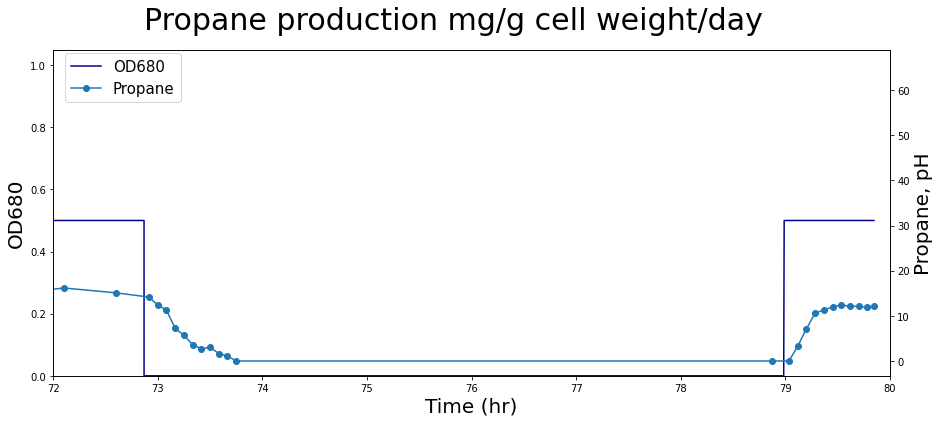

In [27]:
plot_fermentation(72,80,plotph=False, plotOD=False,lightconnected=True, cumulative=False)

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

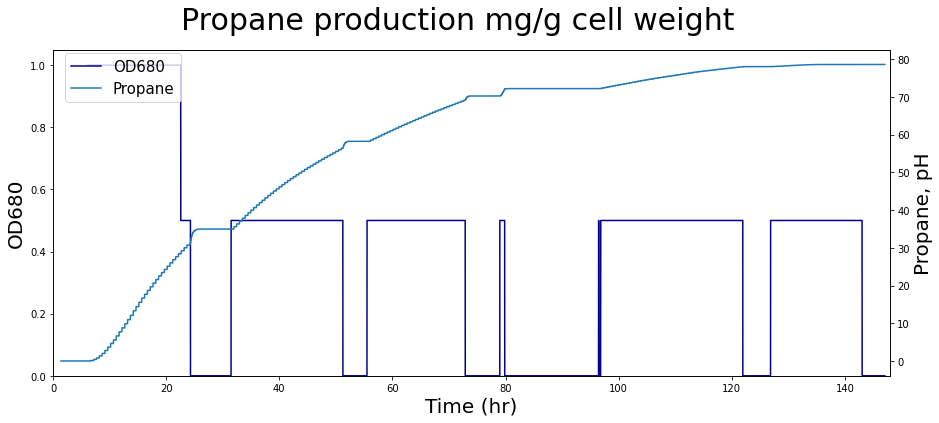

In [39]:
plot_fermentation(0,148,False,False,True,True)

In [70]:
df.at[len(df['Cumulative Propane'])-1,'Cumulative Propane']

58.08404716954715

In [ ]:
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.legend=
df.columns
df.head()

In [ ]:
np.lookfor('k square')

In [65]:
def plot_fermentation_ph(x1, x2, plotph=True, plotOD=True,lightconnected=False, cumulative=False, hplc=False):
    
    plt.figure()
    x = df['time']
    
    #Temp = df['thermo.temperature']
    Propane = np.array(df['Propane mg/gcells/day']).astype(np.double)
    propanemask = np.isfinite(Propane)
    cumulativepropane = np.array(df['Cumulative Propane']).astype(np.double)
    blue = np.array(df['actinic-lights.light-Blue']).astype(np.double)
    bluemask = np.isfinite(blue)
    OD680 = df['od-sensors.od-680']
    pH = df['probes.ph']
    glucose = np.array(df['Glucose']).astype(np.double)
    lactose = np.array(df['Lactate']).astype(np.double)
    acetate = np.array(df['Acetic Acid']).astype(np.double)
    butyrate = np.array(df['Butyric Acid']).astype(np.double)
    glucosemask = np.isfinite(glucose)
    lactosemask = np.isfinite(lactose)
    acetatemask = np.isfinite(acetate)
    butyratemask = np.isfinite(butyrate)

    fig, ax1 = plt.subplots(figsize=(15,6))

    #first axis
    ax1.set_xlabel('Time (hr)', size=20)
    ax1.set_ylabel('OD680', size=20)
    if(plotOD):
        ax1.plot(x,OD680,color='black',label='OD')
        
    if(hplc):
     #   ax1.plot(x[glucosemask],glucose[glucosemask], linestyle='-', marker='o', color='chocolate',label='Glucose (10^-1 g)')
        ax1.plot(x[acetatemask],acetate[acetatemask], linestyle='-', marker='o', color='gold',label='Acetate (10^-1 g)')
        ax1.plot(x[lactosemask],lactose[lactosemask], linestyle='-', marker='o', color='aquamarine',label='Lactose/Glyerol (10^-1 g)')
        ax1.plot(x[butyratemask],butyrate[butyratemask], linestyle='-', marker='o', color='magenta',label='Butyrate (10^-1 g)')


    
    #second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('pH',size=20)
    
    
    if(plotph):
        ax2.plot(x,pH, color='tab:orange',label='pH')

    ax2.tick_params(axis='y')

    line_labels = ['OD680', 'Acetate','Lactose/Glycero','Butyrate','pH']
    fig.legend([OD680, Propane, blue, pH],     
               labels=line_labels,loc='upper right', bbox_to_anchor=(0.25, .89),prop={'size': 15})
    ax1.set_xlim(xmin=x1,xmax=x2)
    ax2.set_xlim(xmin=x1,xmax=x2)
    ax1.set_ylim(ymin=0)
    #ax2.set_ylim(ymin=0)
    plt.show()
    # colors https://matplotlib.org/stable/gallery/color/named_colors.html

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

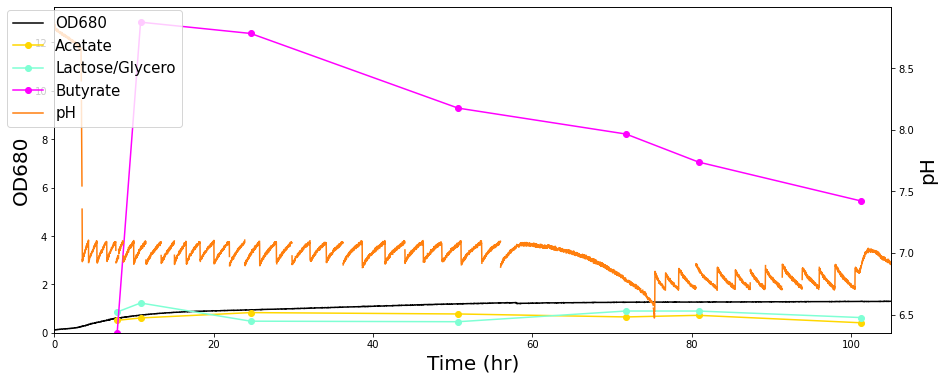

In [66]:
plot_fermentation_ph(0,105,plotph=True, plotOD=True,lightconnected=False, cumulative=False, hplc=True)

In [ ]:
butyrate_starting_mol = 3.5
df['Butyric Acid'] = butyrate_starting_mol - df['Butyric Acid']/(88.1)*44
def expected_yield(x1, x2, cumulative=True, hplc=True):
    
    plt.figure()
    x = df['time']
    
    #Temp = df['thermo.temperature']
    Propane = np.array(df['Propane mg/gcells/day']).astype(np.double)
    propanemask = np.isfinite(Propane)
    cumulativepropane = np.array(df['Cumulative Propane']).astype(np.double)
    
    glucose = np.array(df['Glucose']).astype(np.double)
    lactose = np.array(df['Lactate']).astype(np.double)
    acetate = np.array(df['Acetic Acid']).astype(np.double)
    butyrate = np.array(df['Butyric Acid']).astype(np.double)
    glucosemask = np.isfinite(glucose)
    lactosemask = np.isfinite(lactose)
    acetatemask = np.isfinite(acetate)
    butyratemask = np.isfinite(butyrate)

    fig, ax1 = plt.subplots(figsize=(15,6))

    #first axis
    ax1.set_xlabel('Time (hr)', size=20)
    ax1.set_ylabel('Butyrate conversion', size=20)

    if hplc:
       # ax1.plot(x[glucosemask],glucose[glucosemask], linestyle='-', marker='o', color='chocolate',label='Glucose (10^-1 g)')
       # ax1.plot(x[acetatemask],acetate[acetatemask], linestyle='-', marker='o', color='gold',label='Acetate (10^-1 g)')
       # ax1.plot(x[lactosemask],lactose[lactosemask], linestyle='-', marker='o', color='aquamarine',label='Lactose/Glyerol (10^-1 g)')
        ax1.plot(x[butyratemask],butyrate[butyratemask], linestyle='-', marker='o', color='magenta',label='Butyrate (10^-1 g)')

    #second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Propane, pH',size=20)
    
    if not cumulative:
        ax2.plot(x[propanemask],Propane[propanemask], linestyle='-', marker='o', color='tab:blue',label='Propane (mg/gcell/day)')
        fig.suptitle('Propane production mg/g cell weight/day ',  fontsize=30)
        if(plotph):
            ax2.plot(x,pH, color='tab:orange',label='pH')
    else:
        ax2.plot(x,cumulativepropane, color='tab:blue',label='Propane (mg/gcell)')
        fig.suptitle('Propane production mg/g cell weight',  fontsize=30)
    ax2.tick_params(axis='y')

    line_labels = ['OD680', 'Propane', 'Light', 'pH']
    fig.legend([OD680, Propane, blue, pH],     
               labels=line_labels,loc='upper right', bbox_to_anchor=(0.25, .89),prop={'size': 15})
    ax1.set_xlim(xmin=x1,xmax=x2)
    ax2.set_xlim(xmin=x1,xmax=x2)
    ax1.set_ylim(ymin=0)
    #ax2.set_ylim(ymin=0)
    plt.show()
    # colors https://matplotlib.org/stable/gallery/color/named_colors.html